# Importing Libraries

In [2]:
from scipy.io import loadmat, savemat

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import seaborn as sns

from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import KernelPCA



c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])
# print(os.environ['SHELL'])


dslab


# Loading Data

Select the dataset you want to work with by setting the variable 'dataset_name'

In [4]:
def read_HSI(dataset):
    if dataset == 'Salinas':
        data = loadmat('../Datasets/Salinas/Salinas_corrected.mat')['salinas_corrected']
        gt = loadmat('../Datasets/Salinas/Salinas_gt.mat')['salinas_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
    elif dataset == 'IndianPines':
        data = loadmat('../Datasets/IndianPines/Indian_pines_corrected.mat')['indian_pines_corrected']
        gt = loadmat('../Datasets/IndianPines/Indian_pines_gt.mat')['indian_pines_gt']
        print(f"data shape: {data.shape}\ngt shape: {gt.shape}")
        return data, gt
def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  # df.to_csv(f'./Datasets/Raw/{dataset_name}/{dataset_name}.csv')
  return df
    
# dataset_name = 'IndianPines'
dataset_name = 'Salinas'
data, gt = read_HSI(dataset=dataset_name)

df = extract_pixels(data, gt)
print(f"df shape: {df.shape}")

if dataset_name == 'Salinas':
    class_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow',
                    'Fallow_rough_plow','Fallow_smooth','Stubble','Celery',
                    'Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green',
                    'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk',
                    'Lettuce_romaine_7wk','Vinyard_untrained','Vinyard_vertical']
elif dataset_name == 'IndianPines':
    class_name = [ "Alfalfa", "Corn-notill", "Corn-mintill","Corn", "Grass-pasture", 
                    "Grass-trees","Grass-pasture-mowed", "Hay-windrowed", "Oats",
                    "Soybean-notill", "Soybean-mintill", "Soybean-clean","Wheat",
                    "Woods", "Buildings-Grass-Trees-Drives","Stone-Steel-Towers"]
    


data shape: (512, 217, 204)
gt shape: (512, 217)
df shape: (111104, 205)


# Visualizing Dataset

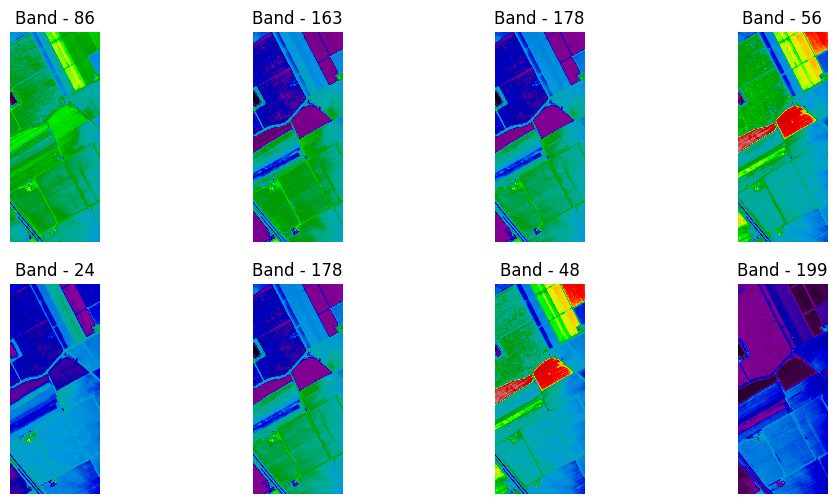

In [5]:
#Spectral bands
fig = plt.figure(figsize = (12, 6))

for i in range(1, 8+1):
    fig.add_subplot(2,4, i)
    q = np.random.randint(data.shape[2])
    plt.imshow(data[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


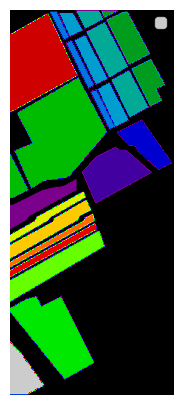

In [6]:
# Ground Truth
plt.figure(figsize=(10, 5))
plt.imshow(gt, cmap='nipy_spectral')
# plt.colorbar
plt.legend()
plt.axis('off')
plt.show()

# Dimensionality Reduction

## Utils

In [54]:
from sklearn.preprocessing import StandardScaler


def show_random_bands(df_dr):
    fig = plt.figure(figsize = (20, 10))

    random_bands = random.sample(range(1, df_dr.shape[1]), 8)
    for i in range(1, 8+1):
        fig.add_subplot(2,4, i)
        plt.imshow(df_dr.loc[:, f'Band-{random_bands[i-1]}'].values.reshape(y.shape[0], y.shape[1]), cmap='nipy_spectral')
        plt.axis('off')
        plt.title(f'Band - {random_bands[i-1]}')

def normalize_df(df):
    # Separate the features and class columns
    features = df.iloc[:, :-1]
    class_column = df.iloc[:, -1]

    # Normalize the features
    normalized_features = (features - features.min()) / (features.max() - features.min())

    # Concatenate the normalized features with the class column
    return pd.concat([normalized_features, class_column], axis=1)


def standardize_df(df):
    # Separate the features and class columns
    features = df.iloc[:, :-1]
    class_column = df.iloc[:, -1]

    scaler = StandardScaler()
    std_features = scaler.fit_transform(features)

    # Concatenate the normalized features with the class column
    return pd.concat([pd.DataFrame(std_features), class_column], axis=1)

def apply_DR(df, method, n_components):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1:].values

    if method == 'PCA':
        pca = PCA(n_components = n_components, random_state=0)
        dt = pca.fit_transform(X)
    elif method == 'FastICA':
        fast_ica = FastICA(n_components=n_components, whiten='unit-variance', max_iter=400, random_state=0)
        dt = fast_ica.fit_transform(X)
    elif method == 'UMAP':
        umap_reducer = umap.UMAP(n_components=n_components)
        dt = umap_reducer.fit_transform(X)
    elif method == 'TSNE':
        tsne = TSNE(n_components=n_components, method='exact', learning_rate='auto', init='random', perplexity=3)
        dt = tsne.fit_transform(X)
    elif method == 'KPCA':
        transformer = KernelPCA(n_components=n_components, kernel='cosine')
        dt = transformer.fit_transform(X)
    elif method == 'Corr':
        corr = df.iloc[:, :-1].corr()
        # Create an array to track which columns to keep
        columns = np.full((corr.shape[0],), True, dtype=bool)
        # Calculate the average correlation for each feature
        average_correlations = corr.mean().values
        # Get the indices of the top n_components features based on average correlation
        top_indices = np.argsort(average_correlations)[-n_components:]

        # Set the columns to keep based on the top indices
        for idx in range(corr.shape[0]):
            if idx not in top_indices:
                columns[idx] = False

        # Filter the DataFrame to keep only the selected features
        dt = df.iloc[:, :-1].iloc[:, columns]

        # # Display the selected features
        # print("Selected features:\n", df_selected.columns)
        # print("Filtered DataFrame:\n", df_selected.head())
        
    dr_df = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
    dr_df.columns = [f'Band-{i}' for i in range(1,n_components+1)]+['class']

    return dr_df

In [37]:
n_components = 8

## PCA (OK)

In [18]:
def save_data(method, dr_df, X, n_components):
    # saving to .mat
    reshaped_data = np.array([row[1][:-1] for row in dr_df.iterrows()]).reshape((X.shape[0], X.shape[1], n_components))
    savemat(f'../Datasets/{dataset_name}/{dataset_name}_{method}_{n_components}.mat', {'data': reshaped_data})

In [10]:
method='PCA'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,Band-9,Band-10,...,Band-22,Band-23,Band-24,Band-25,Band-26,Band-27,Band-28,Band-29,Band-30,class
0,0.223988,0.177430,0.416330,0.311395,0.325214,0.231882,0.346996,0.470362,0.397216,0.179280,...,0.456992,0.247774,0.493248,0.420316,0.397764,0.092318,0.068391,0.344789,0.354762,0
1,0.222203,0.177883,0.409545,0.313663,0.325894,0.219493,0.342972,0.462899,0.408863,0.178284,...,0.449913,0.252844,0.463882,0.418714,0.420532,0.107494,0.068449,0.345019,0.355654,0
2,0.217412,0.171852,0.410646,0.312500,0.328519,0.218675,0.349522,0.472170,0.395074,0.178589,...,0.451077,0.247309,0.465114,0.417410,0.400725,0.083794,0.075139,0.337977,0.362040,0
3,0.210805,0.164432,0.416560,0.310570,0.331277,0.220304,0.346731,0.475160,0.393752,0.178313,...,0.447711,0.248403,0.489548,0.442966,0.384191,0.077649,0.073393,0.329075,0.380757,0
4,0.203409,0.159336,0.420668,0.309615,0.329350,0.218251,0.345371,0.469335,0.395712,0.181298,...,0.453013,0.246359,0.494154,0.426749,0.393313,0.100735,0.065126,0.350106,0.374899,0


## FastICA (OK)

In [11]:
method='FastICA'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,Band-9,Band-10,...,Band-22,Band-23,Band-24,Band-25,Band-26,Band-27,Band-28,Band-29,Band-30,class
0,0.656500,0.350774,0.530219,0.631893,0.326546,0.368959,0.453117,0.531201,0.155458,0.631354,...,0.426538,0.561569,0.508905,0.687339,0.415259,0.444005,0.579844,0.288916,0.813896,0
1,0.662422,0.357699,0.525284,0.627839,0.317587,0.371153,0.446032,0.539460,0.161091,0.640741,...,0.429082,0.467289,0.497131,0.672136,0.406248,0.430249,0.571384,0.288166,0.813239,0
2,0.688195,0.355366,0.510947,0.617470,0.337480,0.369003,0.465152,0.479102,0.153542,0.614981,...,0.421437,0.582582,0.504996,0.678814,0.414848,0.440561,0.588555,0.274532,0.810782,0
3,0.679185,0.353546,0.512379,0.630901,0.322122,0.371008,0.450507,0.483799,0.163159,0.637490,...,0.427306,0.602577,0.502319,0.689601,0.411951,0.436898,0.578464,0.275178,0.812354,0
4,0.648186,0.355885,0.550089,0.636246,0.314782,0.371415,0.440322,0.588862,0.164591,0.651035,...,0.424800,0.720840,0.506461,0.676164,0.413116,0.439933,0.575293,0.288212,0.815776,0


In [12]:
dr_df.head()

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,Band-9,Band-10,...,Band-22,Band-23,Band-24,Band-25,Band-26,Band-27,Band-28,Band-29,Band-30,class
0,-0.238834,-0.038964,0.457274,0.167691,0.808106,2.120514,0.238288,0.315018,0.500776,-0.028158,...,-0.432505,0.367383,0.087134,0.017262,0.719493,0.455146,-0.898769,0.311295,-0.168301,0
1,-0.136740,0.659367,0.285451,-0.023519,0.354576,2.397199,-0.044910,0.385447,0.920833,0.187094,...,-0.188379,-0.480520,-0.337971,-0.270006,0.414001,-0.315923,-1.143834,0.255041,-0.284404,0
2,0.307543,0.424130,-0.213711,-0.512591,1.361647,2.126041,0.719383,-0.129210,0.357920,-0.403628,...,-0.922197,0.556355,-0.053970,-0.143833,0.705571,0.262087,-0.646448,-0.767313,-0.718369,0
3,0.152224,0.240508,-0.163838,0.120877,0.584128,2.378924,0.133968,-0.089159,1.075015,0.112560,...,-0.358864,0.736185,-0.150643,0.059999,0.607349,0.056756,-0.938747,-0.718876,-0.440635,0
4,-0.382142,0.476441,1.149117,0.372981,0.212553,2.430268,-0.273190,0.806686,1.181785,0.423167,...,-0.599379,1.799777,-0.001106,-0.193892,0.646835,0.226889,-1.030603,0.258512,0.163765,0


## UMAP (OK)

In [49]:
method='UMAP'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm

,Band-1,Band-2,Band-3,Band-4,Band-5,Band-6,Band-7,Band-8,class
0,0.251122,0.416373,0.131235,0.584248,0.137912,0.413785,0.285646,0.451988,0
1,0.251240,0.416063,0.130889,0.584121,0.137455,0.413946,0.287324,0.453709,0
2,0.254756,0.420882,0.135542,0.587178,0.133834,0.413266,0.262923,0.437674,0
3,0.257857,0.425233,0.139357,0.591662,0.133486,0.413219,0.228581,0.417608,0
4,0.255107,0.426099,0.140019,0.592159,0.144041,0.413363,0.209261,0.401884,0
...,...,...,...,...,...,...,...,...,...
111099,0.254855,0.443593,0.146148,0.377062,0.166540,0.529294,0.697834,0.979913,0
111100,0.257185,0.446202,0.148126,0.376183,0.170441,0.531196,0.703505,0.986045,0
111101,0.255718,0.444077,0.146110,0.376293,0.167089,0.529624,0.699138,0.981239,0
111102,0.256320,0.445003,0.146985,0.376317,0.168622,0.530255,0.701293,0.983677,0


## T-SNE (Crashing memory)

In [9]:
# PROBLEM: Causing MemoryError: Unable to allocate 46.0 GiB for an array with shape (111104, 111104) and data type float32


method='TSNE'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)


MemoryError: Unable to allocate 9.12 GiB for an array with shape (34995, 34995) and data type float64

## Kernel PCA (Crashing memory)

In [23]:
method='KPCA'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)
dr_df_norm.head()


MemoryError: Unable to allocate 92.0 GiB for an array with shape (111104, 111104) and data type float64

# Feature Selection

## Lasso Regression (Not converging)

In [32]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# df_lasso = normalize_df(df)
df_lasso = standardize_df(df)
X = df_lasso.iloc[:, :-1].values
y = df_lasso.iloc[:, -1:].values


# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()


# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(X, y)
print("Best Params {}".format(lasso_cv.best_params_))

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.874e+05, tolerance: 2.362e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.858e+05, tolerance: 2.355e+02
  model = cd_fast.enet_coordinate_descent(
c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

Best Params {'alpha': 1e-05}


c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.332e+05, tolerance: 2.945e+02
  model = cd_fast.enet_coordinate_descent(


In [31]:


# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001, max_iter=10000)
lasso1.fit(X, y)

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.696e+05, tolerance: 2.945e+02
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-05, max_iter=10000)

In [14]:
# Get the absolute values of the coefficients
coef_abs = np.abs(lasso.coef_)

# Get indices of the top n_components features
top_n_indices = np.argsort(coef_abs)[-n_components:]

# Get the names of the selected features
selected_features = X.columns[top_n_indices]

# Filter the original DataFrame to keep only the selected features
X_selected = X[selected_features]

# Display the selected features
print("Selected features:", selected_features)
print("Filtered DataFrame:\n", X_selected.head())

AttributeError: 'Lasso' object has no attribute 'coef_'

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)

## Correlation Based (OK)

In [55]:
method='Corr'
dr_df = apply_DR(df, method=method, n_components=n_components)
dr_df_norm = normalize_df(dr_df)
# show_random_bands(dr_df_norm)
save_data(method, dr_df_norm, data, n_components)

## Random Forest feature importance

In [33]:
from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier for classification


df_lasso = standardize_df(df)
X = df_lasso.iloc[:, :-1].values
y = df_lasso.iloc[:, -1:].values

# Fit the Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances and sort them
feature_importances = rf.feature_importances_
top_n_indices = np.argsort(feature_importances)[-n_components:]

# Get the names of the selected features
selected_features = X.columns[top_n_indices]

# Filter the original DataFrame to keep only the selected features
X_selected = X[selected_features]

# Display the selected features
print("Selected features:", selected_features)
print("Filtered DataFrame:\n", X_selected.head())

c:\Users\Dell\anaconda3\envs\dslab\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


KeyboardInterrupt: 